In [43]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [5]:
import platform
print("System processor:", platform.processor(), '\n')
!nvidia-smi

System processor: x86_64 

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
import os
os.environ['KAGGLE_USERNAME'] = '******************'
os.environ['KAGGLE_KEY'] = '****************************'

## Fetch the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.15G/1.15G [00:14<00:00, 89.3MB/s]
100% 1.15G/1.15G [00:14<00:00, 83.0MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

In [0]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

## Little bit of visualization

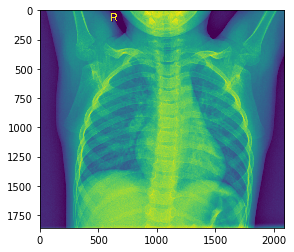

In [15]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
def plot_images(path, max_images=6):
  image_no = 0
  rows = max_images//3 +1
  fig = plt.figure(figsize=(10, 10))
  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if image_no == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(rows*100+31+image_no)
      if path.split("/")[-1]=="PNEUMONIA":
        plt.title(file.split('_')[1].capitalize())
      else:
        plt.title("Normal")
      imgplot = plt.imshow(img)
      image_no += 1

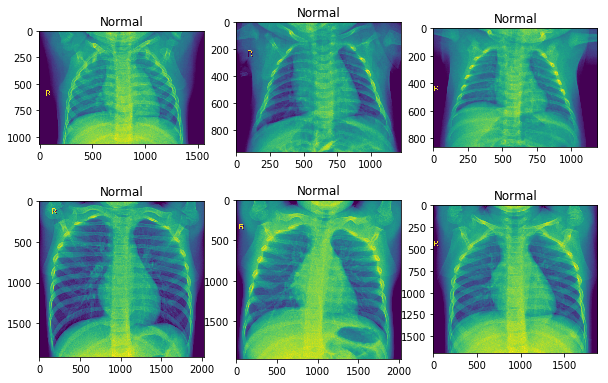

In [32]:
plot_images(training_dir + '/NORMAL')

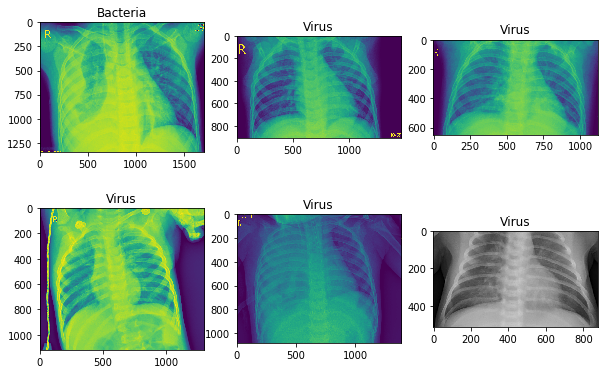

In [33]:
plot_images(training_dir + '/PNEUMONIA')

## Compile the model

In [35]:
NUM_CLASSES = 2

def create_model(input_shape, num_classes):
  K.clear_session()

  base_model = InceptionV3(weights='imagenet', include_top=False,
                           input_shape=input_shape)
  
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)

  for layer in base_model.layers:
    layer.trainable = False
  
  predictions = Dense(num_classes, activation='sigmoid')(x)

  model = Model(inputs=base_model.inputs, outputs=predictions)

  return model

model = create_model((150, 150, 3), NUM_CLASSES)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 1s 0us/step


In [40]:
training_loss = Mean('training_loss', dtype=tf.float32)

training_accuracy = SparseCategoricalAccuracy('training_accuracy', dtype=tf.float32)

test_loss = Mean('test_loss', dtype=tf.float32)

test_accuracy = SparseCategoricalAccuracy('test_accuracy', dtype=tf.float32)

# Print model summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [44]:

rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [46]:
from sklearn.utils.class_weight import compute_class_weight
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


## Train the model

In [48]:
# Start the training
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=10,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              class_weight=train_class_weights,
                              workers=20)

# Save the model after the training is complete
MODEL_FILE = 'pneumonia_inceptionv3_v1.hd5'
model.save(MODEL_FILE)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
163/163 [==============================] - 394s 2s/step - loss: 0.5091 - acc: 0.7592 - val_loss: 0.9387 - val_acc: 0.4359
Epoch 2/10
163/163 [==============================] - 389s 2s/step - loss: 0.3253 - acc: 0.8677 - val_loss: 0.7587 - val_acc: 0.6843
Epoch 3/10
163/163 [==============================] - 381s 2s/step - loss: 0.2921 - acc: 0.8779 - val_loss: 0.7346 - val_acc: 0.6859
Epoch 4/10
163/163 [==============================] - 380s 2s/step - loss: 0.2823 - acc: 0.8844 - val_loss: 0.8247 - val_acc: 0.7067
Epoch 5/10
163/163 [==============================] - 378s 2s/step - loss: 0.2510 - acc: 0.8965 - val_loss: 0.9927 - val_acc: 0.7083
Epoch 6/10
163/163 [==============================] - 384s 2s/step - loss: 0.2501 - acc: 0.9030 - val_loss: 1.0997 - val_acc: 0.7083
Epoch 7/10
163/163 [==============================] - 384s 2s/step - loss: 0.2436 - acc: 0.8999 - val_loss: 

In [0]:
# Move the trained model to the Google Drive
!mv {MODEL_FILE} '/content/drive/My Drive/Documents'

In [64]:
# Load the Model from Google Drive 
MODEL_FILE = f'/content/drive/My Drive/Documents/{MODEL_FILE}'
model = tf.keras.models.load_model(MODEL_FILE)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Evaluate the model

In [104]:
# Run the model on Test Data 
result = model.evaluate_generator(test_generator, steps=len(test_generator),\
                                  verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

16/16 [==============================] - 2s 100ms/step - loss: 1.1639 - acc: 0.6875
Loss     : 1.16  
Accuracy : 68.75%


In [105]:
# Randomly generate the Test Batch No
num_of_batch = len(test_generator) # This is 1 in our case 
batch_no = np.random.randint(0, num_of_batch - 1)

# Fetch the batch data
y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

# Make the predictions 
y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

# Print the results 
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true_batch==y_pred_batch)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 8
-----------------------------------
Batch Size              : 1
-----------------------------------
Accuracy                : 100.00%
-----------------------------------


In [0]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

## Visualize results

In [0]:
def predict_images(images_path, label, max_images=6):
  image_no = 0
  rows = max_images//3 +1
  fig = plt.figure(figsize=(15, 10))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if image_no == max_images:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(rows*100+31+image_no)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[image_no] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      image_no += 1

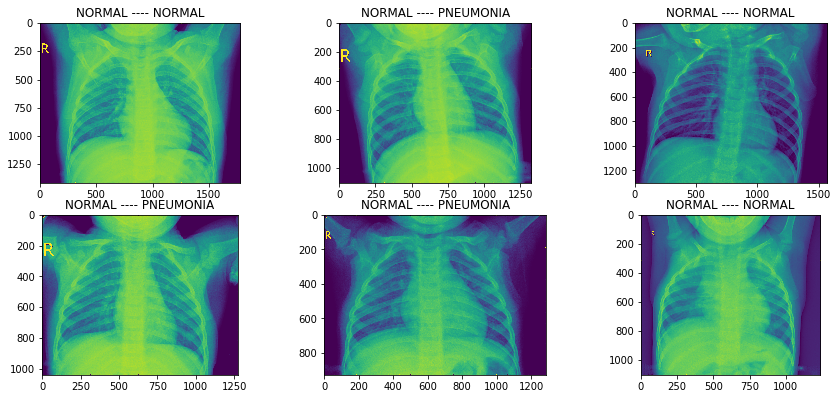

In [114]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

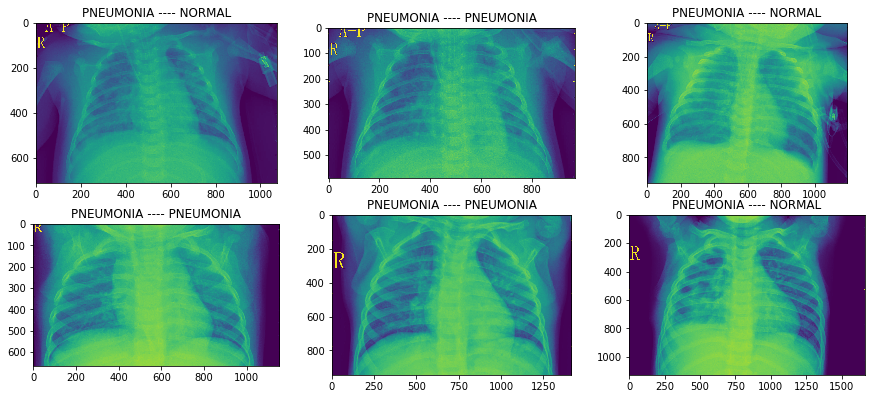

In [115]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')